### Generating DNA dataset for motif detection & implementing Differential Privacy on data

In [ ]:
# Install required packages
!pip install ipynb
!pip install import-ipynb

In [2]:
# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Import necessary libraries
import time
import random
import matplotlib.pyplot as plt
from google.colab import drive


In [3]:
# Define path to fetch the ipynb file
import sys
sys.path.append('/content/drive/MyDrive/Motif-Detection/Py-files/Utils/')

# Import ipynb needed to access required functions
import import_ipynb
from file_io import save_generated_data_to_respective_files
from info_content_ops import obtain_info_content_per_column
from visualization import visualize_sequence_generation_times


## All necessary functions that deal with data generation, motif positioning, information content extraction, storing results etc. are defined below

In [4]:
# Function to generate a random sequence of certain length based on nucleotide probabilities
# Input: sequence_length (Integer), nucleotide_prob (Integer array of size 4)
# Output: sequence (String of length sequence_length)

def generate_sequence(sequence_length, nucleotide_prob):
	sequence = []
  
	for i in range(0, sequence_length):
		random_probability = random.random()
		if random_probability < nucleotide_prob[0]:
			sequence.append(nucleotides[0])
		elif random_probability < nucleotide_prob[0] + nucleotide_prob[1]:
			sequence.append(nucleotides[1])
		elif random_probability < nucleotide_prob[0] + nucleotide_prob[1] + nucleotide_prob[2]:
			sequence.append(nucleotides[2])
		else:
			sequence.append(nucleotides[3])
	 
	return ''.join(sequence)
 

In [5]:
# Function to plant a randomly chosen motif at a random position in the given sequence
# Input: seq_to_modify (String), motifs (Array of motif Strings), motif_length (Integer), 
# 			 sequence_length (Integer), sequence_count (Integer (Max. no. of motifs available))
# Output: modified_sequence (String which is obtained by inserting randomized_motif in seq_to_modify)

def plant_motifs_in_sequence(seq_to_modify, motifs, motif_length, sequence_length, sequence_count):
	random_plant_position = random.randrange(0, sequence_length - motif_length)
	random_motif_position = random.randrange(0, sequence_count)
	modified_sequence = seq_to_modify[:random_motif_position] + motifs[random_motif_position] + seq_to_modify[random_motif_position + motif_length:]
	
	return modified_sequence, random_motif_position


In [6]:
# Function to generate sequence_count no. of random sequences of size sequence_length
# Input: sequence_count (Integer), sequence_length (Integer), nucleotide_prob (List)
# Output: sequences (List of sequence_count no. of sequences each of sequence_length size)
#         generation_time (Float describing the time taken to generate sequences)

def generate_sequences_of_given_count(sequence_count, sequence_length, nucleotide_prob):
  start_time = time.perf_counter()
  sequences = []
  
  for count in range(0, sequence_count):
    generated_sequence = generate_sequence(sequence_length, nucleotide_prob)
    sequences.append(generated_sequence)
  print("\nNo. of sequences: ", len(sequences))  
  print("A sample sequence looks like: ", sequences[0])
  end_time = time.perf_counter()
  generation_time = round(end_time - start_time, 2)

  return sequences, generation_time
  

## Performing actual data genaration for further use

In [7]:
# Establish connection to use Google drive
drive.mount("/content/drive")
base_path = "drive/MyDrive/Motif-Detection/Data/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Define constants needed
nucleotides = ['A', 'G', 'T', 'C']
nucleotide_prob = [0.25, 0.25, 0.25, 0.25]

# ICPC: information_content_per_column = float(input()) # [0, 2]
# Typically rounded down to two decimal digits
icpc = 1.02 

# Generally 5-20 base pairs long
motif_length = 40 

# General length of a dna sequence is 150 base pairs
sequence_length = 300

# For analysis, we generate different no. of dna sequences
sequence_counts = [1000, 5000, 10000, 50000, 100000]

# For analysis, we store sequence generation times for various length 
sequence_generation_times = []


In [9]:
# Obtain probability associated with information content per column
icpc_path = base_path + "icpc_p_map.txt"
icpc_prob = obtain_info_content_per_column(icpc_path)
icpc_probability = [icpc_prob[i][1] for i in range(0, len(icpc_prob)) if round(icpc, 2) == icpc_prob[i][0]]
icpc_probability = icpc_probability[0]

# Obtain normalized probabilities by performing (1 - prob) / (1 + max_icpc)
normalized_prob = (1 - icpc_probability) / 3.0

# Generate a random motif and save it to random_motif.txt
random_motif = generate_sequence(motif_length, nucleotide_prob)


In [10]:
# Generate DNA sequences of different sequence counts
for sequence_count in sequence_counts:

  # Start the timer to track generation times
  start_time = time.perf_counter()
  
  # Generate sequences of given sequence count
  sequences = []
  for i in range(0, sequence_count):
    seq = generate_sequence(sequence_length, nucleotide_prob)
    sequences.append(seq)

  # Generate motif_length no. of random motifs of size sequence_count using
  # the previously generated random motif to re-assign probability values
  generated_motifs = []
  for i in range(0, motif_length):
    motif_prob = [normalized_prob, normalized_prob, normalized_prob, normalized_prob]
    for j in range(0, len(nucleotides)):
      if random_motif[i] == nucleotides[j]:
        motif_prob[j] = icpc_probability
    generated_motif = generate_sequence(sequence_count, motif_prob)
    generated_motifs.append(generated_motif)

  # Generate sequence_count no. of random motifs of size motif_length
  motifs = []
  for i in range(0, sequence_count):
    motif = []
    for j in range(0, motif_length):
      motif.append(generated_motifs[j][i])
    motifs.append(''.join(motif))

  print("\nNo. of motifs: ", len(motifs))
  print("A motif looks like: ", motifs[0])

  # Constructing the Positional Weight Matrix or Profile Matrix
  # to analyze the counts associated with nucleotides
  profile_matrix = []
  for i in range(0, motif_length):
    counts = [0, 0, 0, 0]
    for j in range(0, sequence_count):
      for k in range(0, len(nucleotides)):
        if motifs[j][i] == nucleotides[k]:
          counts[k] = counts[k] + 1
    profile_matrix.append(counts)

  print("\nNo. of rows in profile_matrix: ", len(profile_matrix))
  print("No. of columns in profile matrix: ", len(profile_matrix[0]))
  print("A sample row in profile matrix looks like: ", profile_matrix[0], "\n")

  # Plant as many motifs as sequence_count in sequences to enforce differential privacy
  modified_sequences = []
  random_positions = []
  for i in range(0, sequence_count):
    modified_sequence, random_position = plant_motifs_in_sequence(sequences[i], motifs, motif_length, sequence_length, sequence_count)
    modified_sequences.append(modified_sequence)
    random_positions.append(random_position)

  # Save results to respective files
  save_generated_data_to_respective_files(base_path, sequence_count, modified_sequences, random_motif, random_positions, profile_matrix)

  # End the timer to stop and save the total generation time
  end_time = time.perf_counter()
  sequence_generation_times.append(round(end_time - start_time, 2))
  print("**********************************")



No. of motifs:  1000
A motif looks like:  ACTGAGCCACTGCGCACCCCCCCTACTTGGCGTGGGGCGA

No. of rows in profile_matrix:  40
No. of columns in profile matrix:  4
A sample row in profile matrix looks like:  [829, 51, 54, 66] 

**********************************

No. of motifs:  5000
A motif looks like:  CCTGAGCCCATGTCGAGCCCCCCGAGATGGCTTGTGTCCA

No. of rows in profile_matrix:  40
No. of columns in profile matrix:  4
A sample row in profile matrix looks like:  [4061, 302, 320, 317] 

**********************************

No. of motifs:  10000
A motif looks like:  ACTGAACCACTGCCCACTCACACTAGTTGGAGTGAGTTCA

No. of rows in profile_matrix:  40
No. of columns in profile matrix:  4
A sample row in profile matrix looks like:  [8219, 600, 576, 605] 

**********************************

No. of motifs:  50000
A motif looks like:  AGTGAGCGACTGCCCACTCCAACATTTTGGCGCGCGTCAA

No. of rows in profile_matrix:  40
No. of columns in profile matrix:  4
A sample row in profile matrix looks like:  [40774, 3059, 3050, 3

## Visualizing the relation between sequence count and generation times

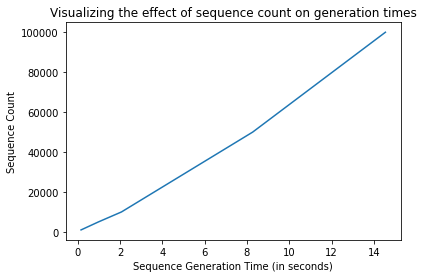

In [11]:
# Plot the generation times and sequence_count to visualize data generation times
visualize_sequence_generation_times(sequence_generation_times, sequence_counts)
